# I. Data Preparation
In this initial section, we load the raw dataset, process the timestamps, and perform essential unit conversions. The data is
 then aggregated into annual means to prepare for long-term trend and relationship analysis.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.style.use('dark_background')

plt.rcParams.update({
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'savefig.facecolor': 'black',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white'
})
# Load data and convert time string to datetime format
df = pd.read_csv("project_1.csv")
df["time"] = pd.to_datetime(df["time"])
df["year"] = df["time"].dt.year

# Convert units for precipitation, temperature, and specific humidity
df["PRECT_mm"] = df["PRECT"] * 86400 * 1000 * 365 # Total annual precipitation
df["TREFHT_C"] = df["TREFHT"] - 273.15            # Kelvin to Celsius (°C)
df["QBOT_g_kg"] = df["QBOT"] * 1000               # kg/kg to g/kg

# Aggregate variables into annual means
annual_mean = df.groupby("year")[["TREFHT_C", "PRECT_mm", "FSNS", "FLNS", "QBOT_g_kg", "UBOT", "VBOT"]].mean().reset_index()
years = annual_mean["year"]

# II. Trend Analysis
## 1. Temperature Trend & Seasonal Distribution
In this section, we analyze the long-term trend and seasonal patterns of temperature. The line chart clearly demonstrates a steady long-term global warming effect in the region. To complement this, a heatmap of monthly mean temperature is introduced to visualize the seasonal cycle across the decades, vividly highlighting the intensification of summer heat in the latter half of the 21st century.

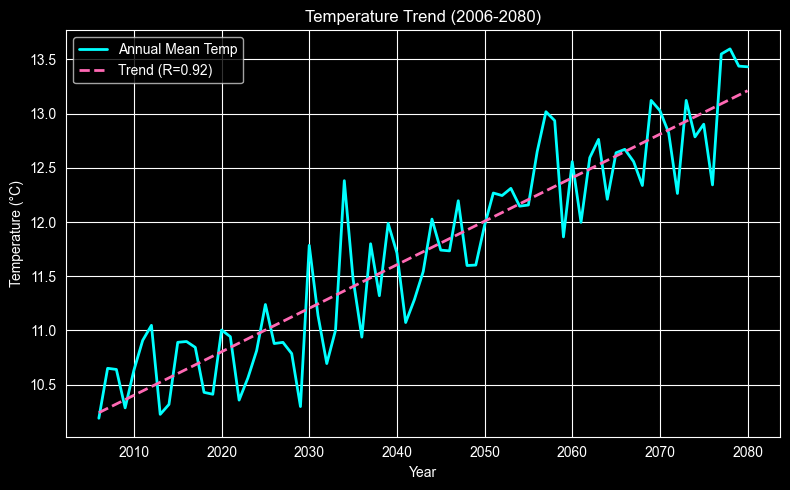

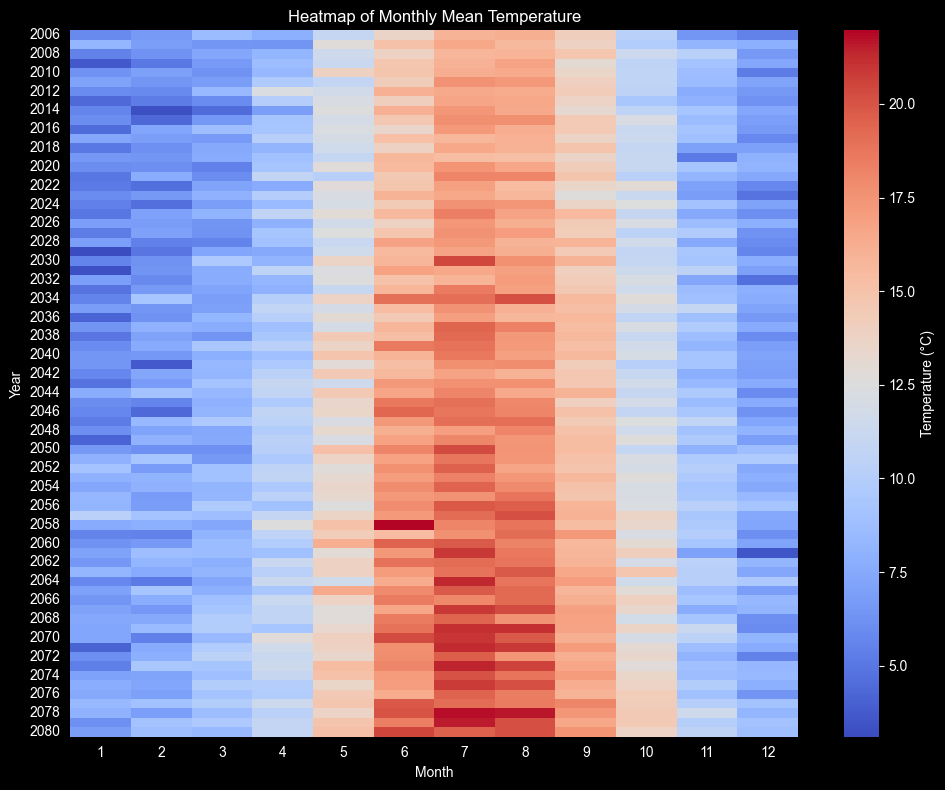

In [25]:
import seaborn as sns
# Temperature Trend Line Plot
plt.figure(figsize=(8, 5))

y_temp = annual_mean["TREFHT_C"]
slope, intercept, r_val, p_val, std_err = linregress(years, y_temp)

plt.plot(years, y_temp, linewidth=2, color='cyan', label="Annual Mean Temp")
plt.plot(years, intercept + slope * years, color='hotpink', linestyle='--', linewidth=2, label=f"Trend (R={r_val:.2f})")

plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trend (2006-2080)")
plt.legend()
plt.tight_layout()
plt.show()

# Monthly Mean Temperature Heatmap
# Extract month
df['Month'] = df['time'].dt.month

# Create a pivot table for monthly mean temperature
heatmap_data_temp = df.pivot_table(
    values='TREFHT_C',
    index='year',
    columns='Month',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_temp,
    cmap='coolwarm',
    annot=False,
    cbar_kws={'label': 'Temperature (°C)'}
)

plt.title('Heatmap of Monthly Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

## 2. Precipitation Trend & Seasonal Distribution
This section visualizes the annual precipitation trend alongside a heatmap of monthly total precipitation. While the long-term annual precipitation trend shows high inter-annual variability and a less prominent monotonic change, the heatmap distinctly captures the seasonal distribution of rainfall, differentiating wetter months from drier ones over the 75-year timeframe.

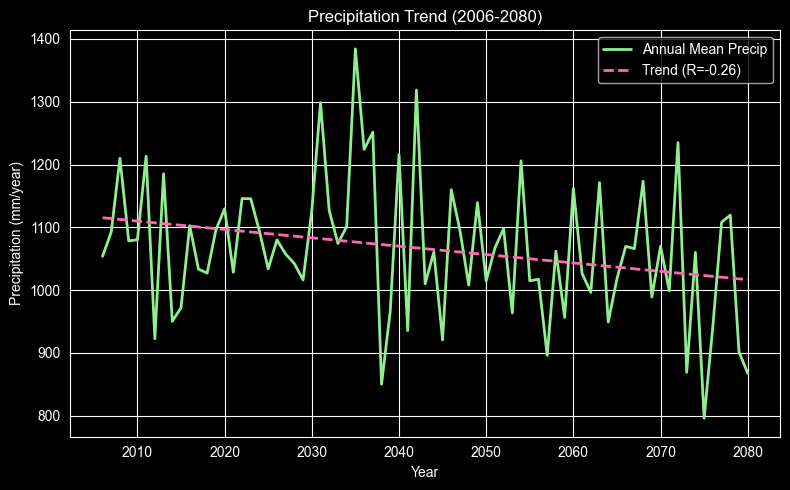

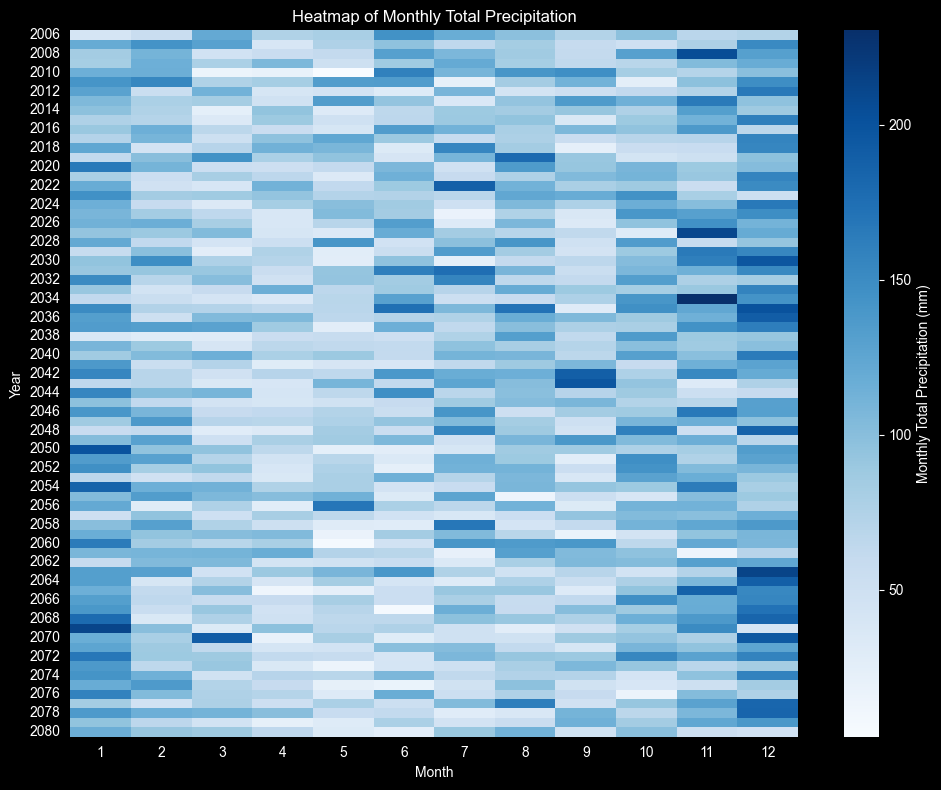

In [26]:
# Precipitation Trend Line Plot
plt.figure(figsize=(8, 5))

y_precip = annual_mean["PRECT_mm"]
slope, intercept, r_val, p_val, std_err = linregress(years, y_precip)

plt.plot(years, y_precip, linewidth=2, color='lightgreen', label="Annual Mean Precip")
plt.plot(years, intercept + slope * years, color='hotpink', linestyle='--', linewidth=2, label=f"Trend (R={r_val:.2f})")

plt.xlabel("Year")
plt.ylabel("Precipitation (mm/year)")
plt.title("Precipitation Trend (2006-2080)")
plt.legend()
plt.tight_layout()
plt.show()

# Monthly Total Precipitation Heatmap
# Unit conversion: m/s → mm/day
df["PRECT_mm_day"] = df["PRECT"] * 86400 * 1000

# Create a pivot table for monthly cumulative precipitation
heatmap_data_precip = df.pivot_table(
    values='PRECT_mm_day',
    index='year',
    columns='Month',
    aggfunc='sum'
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_precip,
    cmap='Blues',
    annot=False,
    cbar_kws={'label': 'Monthly Total Precipitation (mm)'}
)

plt.title('Heatmap of Monthly Total Precipitation')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

## 3. Radiation Trend
Here we plot the surface net solar radiation (FSNS). Variations in radiation reflect changes in cloud cover and atmospheric aerosols over time.

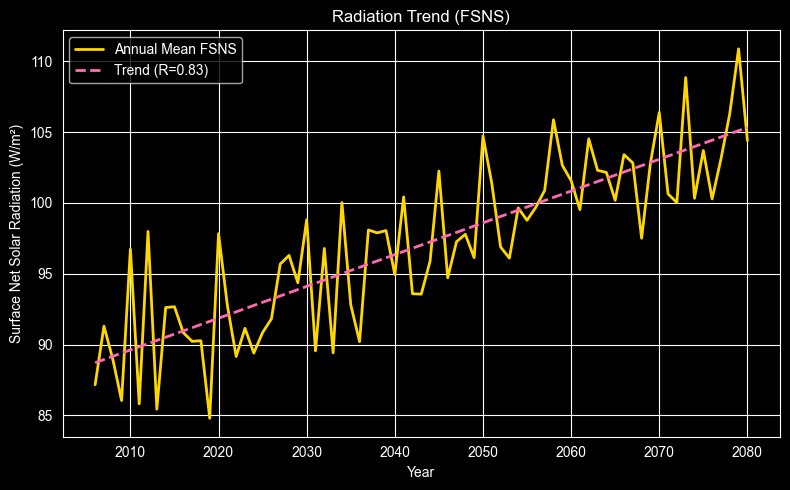

In [27]:
plt.figure(figsize=(8, 5))

# Extract y variable
y_rad = annual_mean["FSNS"]

# Perform linear regression
slope, intercept, r_val, p_val, std_err = linregress(years, y_rad)

# Plot data and trend
plt.plot(years, y_rad, linewidth=2, color='gold', label="Annual Mean FSNS")
plt.plot(years, intercept + slope * years, color='hotpink', linestyle='--', linewidth=2, label=f"Trend (R={r_val:.2f})")

plt.xlabel("Year")
plt.ylabel("Surface Net Solar Radiation (W/m²)")
plt.title("Radiation Trend (FSNS)")
plt.legend()
plt.tight_layout()
plt.show()

# III. Correlation Analysis
## 1. Correlation Matrix
A correlation matrix heatmap is generated to reveal the multivariable linear relationships among temperature, radiation, humidity, wind, and precipitation.

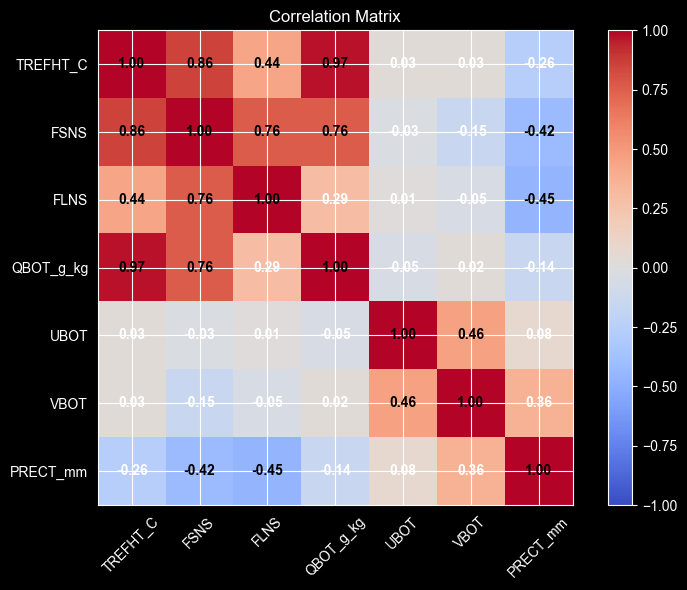

In [28]:
# Select variables for correlation and calculate the matrix
corr_vars = ["TREFHT_C", "FSNS", "FLNS", "QBOT_g_kg", "UBOT", "VBOT", "PRECT_mm"]
corr_matrix = annual_mean[corr_vars].corr()

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the heatmap using imshow
cax = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

# Annotate each cell with the correlation coefficient
for i in range(len(corr_vars)):
    for j in range(len(corr_vars)):
        val = corr_matrix.iloc[i, j]
        text_color = "black" if (val > 0.4 or val < -0.4) else "white"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color, fontweight='bold')

# Configure axes ticks and labels
ax.set_xticks(np.arange(len(corr_vars)))
ax.set_yticks(np.arange(len(corr_vars)))
ax.set_xticklabels(corr_vars, rotation=45)
ax.set_yticklabels(corr_vars)
ax.set_title("Correlation Matrix")

plt.tight_layout()
plt.show()

# IV. Relationship Analysis
## 1. TEMPERATURE–RADIATION RELATIONSHIP
This scatter plot correlates net solar radiation with temperature. The positive linear fit suggests that increased solar radiation (often due to clearer skies) directly contributes to higher surface temperatures.

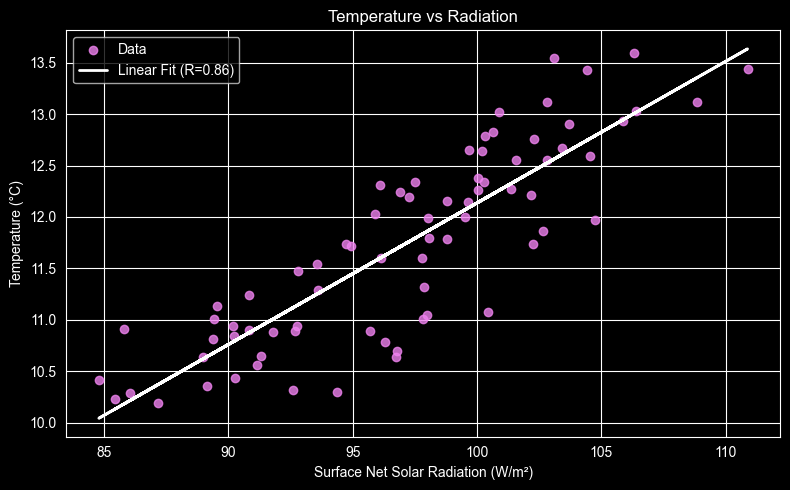

In [29]:
plt.figure(figsize=(8, 5))

x_rad = annual_mean["FSNS"]

# Linear regression
slope, intercept, r_val, p_val, std_err = linregress(x_rad, y_temp)

# Scatter plot and regression line
plt.scatter(x_rad, y_temp, alpha=0.8, color='violet', label="Data")
plt.plot(x_rad, intercept + slope * x_rad, color='white', linestyle='-', linewidth=2, label=f"Linear Fit (R={r_val:.2f})")

plt.xlabel("Surface Net Solar Radiation (W/m²)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature vs Radiation")
plt.legend()
plt.tight_layout()
plt.show()

## 2. TEMPERATURE–QBOT Relationship
This study explores the correlation between specific humidity (QBOT) and temperature. The strong correlation reflects the Clausius-Clapeyron relation, where
 warmer air can hold exponentially more water vapor.

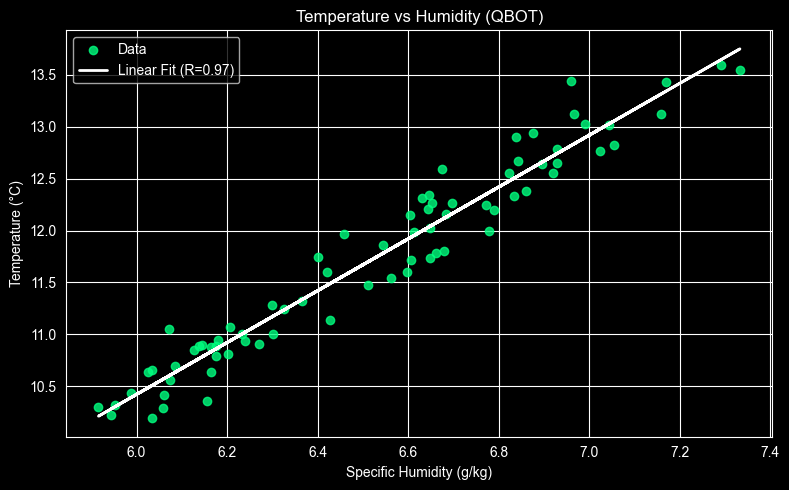

In [30]:
plt.figure(figsize=(8, 5))

x_qbot = annual_mean["QBOT_g_kg"]

# Linear regression
slope, intercept, r_val, p_val, std_err = linregress(x_qbot, y_temp)

# Scatter plot and regression line
plt.scatter(x_qbot, y_temp, alpha=0.8, color='springgreen', label="Data")
plt.plot(x_qbot, intercept + slope * x_qbot, color='white', linestyle='-', linewidth=2, label=f"Linear Fit (R={r_val:.2f})")

plt.xlabel("Specific Humidity (g/kg)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature vs Humidity (QBOT)")
plt.legend()
plt.tight_layout()
plt.show()